In [92]:
"""
Name: Tanishq Saxena
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flag = 0   # 1 means BOW and 0 means Tfidf

# Loading the Dataset from a file in the same directory
dataset_path ="TASK2_dataset.csv"
df =pd.read_csv(dataset_path)

# Merging the "keywords" into a single-coloumn
df['keywords']= df[['keyword_1','keyword_2','keyword_3']].apply(lambda x: ' '.join(x), axis=1)


In [ ]:
# Vectorization of this data using BoW
# BOW simply counts the unique words in the whole corpus
def bow_vectorization(corp):
    vocab =sorted(set(word for doc in corp for word in doc.split()))
    vectors= np.array([[doc.split().count(word) for word in vocab] for doc in corp])
    return vectors

if flag == 1:
    bow_vectors =bow_vectorization(df['keywords'].astype(str).values)

In [ ]:
# Vectorization of this data using TF-IDF
# TF-IDF is first counts the unique words in the corpus (TF) and then multiplies it with IDF
def tfidf_vectorization(corp):
    vocab = sorted(set(word for doc in corp for word in doc.split()))
    N =len(corp)
    term_freq= np.array([[doc.split().count(word) for word in vocab] for doc in corp])
    doc_freq = np.array([sum(1 for doc in corp if word in doc.split()) for word in vocab])
    idf =np.log(N/(doc_freq + 1)) # The +1 factor is for the case where doc_freq is 0
    tfidf = term_freq*idf
    return tfidf

if flag==0:
    tfidf_vectors = tfidf_vectorization(df['keywords'].astype(str).values)

In [95]:
# Applying PCA for reducing the dimensionality
def pca_from_scratch(X,n_components=2):
    X_meaned = X-np.mean(X,axis=0)
    covariance_matrix =np.cov(X_meaned,rowvar=False)
    eigenvalues,eigenvectors =np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors =eigenvectors[:,sorted_indices[:n_components]]
    reduced_data = np.dot( X_meaned, top_eigenvectors)
    return reduced_data

if flag == 1:
    bow_vectors = bow_vectorization(df['keywords'].astype(str).values)
    tfidf_vectors =np.zeros_like(bow_vectors) #Dummy thing
    bow_pca=pca_from_scratch(bow_vectors, 2)
    tfidf_pca=np.zeros_like(bow_pca) #Dummy thing
else:
    tfidf_vectors = tfidf_vectorization(df['keywords'].astype(str).values)
    bow_vectors=np.zeros_like(tfidf_vectors) # Dummy thing
    tfidf_pca=pca_from_scratch(tfidf_vectors, 2)
    bow_pca = np.zeros_like(tfidf_pca) # Dummy thing

combined_embeddings = bow_pca + tfidf_pca

In [96]:
def k_means(X,k,max_iters=100,tol=1e-4):
    np.random.seed(42)
    # Initialize centroids randomly
    centroids = X[np.random.choice(X.shape[0],k,replace=False)]

    for _ in range(max_iters):
        #distances between points and centroids
        distances = np.linalg.norm(X[:,np.newaxis]-centroids,axis=2)     
        clusters = np.argmin(distances,axis=1)
        # Update centroids
        new_centroids=[]
        for j in range(k):
            # If any of the points are in the cluster number 'j' then,
            if np.any(clusters == j):
                new_centroids.append(X[clusters == j].mean(axis=0)) # Make the new centroid as the mean of those elements in the cluster
            else:
                new_centroids.append(centroids[j]) # Let the centroid be the one which it was before (Maybe the one chosen randomly in the starting)
        new_centroids=np.array(new_centroids)
        #Checking for convergence, if the centroid moved less than the tol limit, then the algo stops
        if np.linalg.norm(new_centroids-centroids)<tol:
            break
        centroids=new_centroids
    return clusters

k=5 # Chosen by me because this was giving the highest silhoutte coefficient
clusters=k_means(combined_embeddings,k)
df['Cluster']=clusters


Silhouette Score: 0.6388620425392889


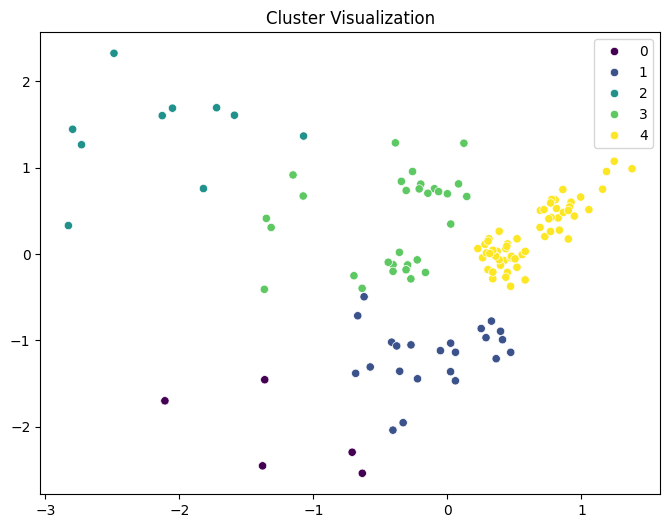

In [97]:
# Calculating the silhouette score manually
def silhouette_score_manual(X, labels):
    labels=pd.Series(labels)
    n = len(X)
    sil_scores=[]
    for i in range(n):
        same_cluster=X[labels[labels==labels[i]].index]
        other_clusters = X[labels[labels != labels[i]].index]
        # a is the mean distance between chosen point and all points in it's cluster 
        a = np.mean(np.linalg.norm(same_cluster-X[i], axis=1))
        # b is the mean distance between chosen point and all points not in it's cluster
        b = np.mean(np.linalg.norm(other_clusters-X[i], axis=1))
        sil_scores.append((b-a)/max(a,b))
    return np.mean(sil_scores)

sil_score =silhouette_score_manual(combined_embeddings,clusters)
print(f'Silhouette Score: {sil_score}')

# Now, Visualizing the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=combined_embeddings[:,0],y=combined_embeddings[:,1],hue=clusters,palette='viridis')
plt.title('Cluster Visualization')
plt.show()
